# Training and Testing notebook

This notebook trains the model using the best set of hyperparameters found by cross-validation. 

It then tests it on the testing data and collects different metrics, saved in [output/metrics.json](output/metrics.json)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import json

from utils import train_test_split
from testing import *
from training.model.net import CNN_LSTM
from training.plot_utils import *
from training.tensor_utils import *
from training.training import *

#for reproducibility
torch.manual_seed(1)
np.random.seed(1)
import random 
random.seed(1)

## Loading needed resources

In [2]:
df = pd.read_csv('data/AAPL-info.csv')

X_train, X_test = train_test_split(df, test_size=0.2)

# parameters
features = ["Open"]  # open must be first features
with open("output/hyperparameters.json", "r") as json_file:
    hyperparams = json.load(json_file)
    forecast_horizon = hyperparams["forecast_horizon"]
    prediction_window = hyperparams["prediction_window"]

# model
model = None
loss = None
optimizer = None
training_losses = []

## Training

In [3]:
# takes about a minute to run
# each iteration trains the model for 50 epochs
for _ in range(3):
    model, loss, optimizer, losses = train_with_hyperparameters(
        X_train,
        0.01,
        0.9,
        features,
        forecast_horizon,
        prediction_window,
        128,
        model=model,
        loss=loss,
        optimizer=optimizer,
    )
    training_losses.extend(losses)

/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


## Plotting predictions

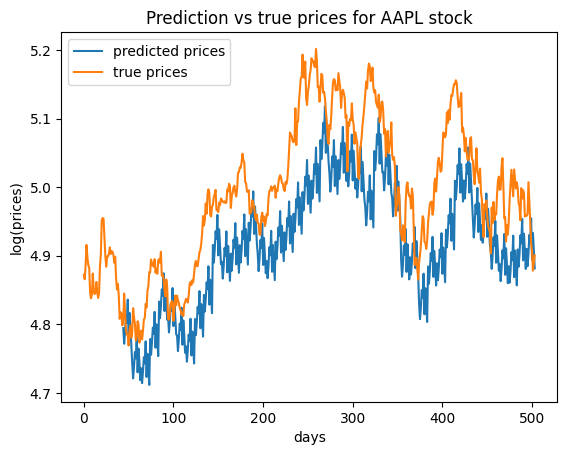

In [4]:
open_prices = X_test.loc[:, features].to_numpy()
plot_prediction_vs_truth(open_prices,model, forecast_horizon, prediction_window, 'AAPL')

## Predicting trends

Testing if the model is accurately predicting if the price will go up or down the following day

In [5]:
trend_accuracy = predict_trend(X_test, model, forecast_horizon, prediction_window)
print(f"predicting trend accuracy: {(trend_accuracy * 100):.2f}%")

predicting trend accuracy: 50.98%


## Testing Error

Mean Square Error (MSE): 0.01
Root Mean Square Error (RMSE): 0.09


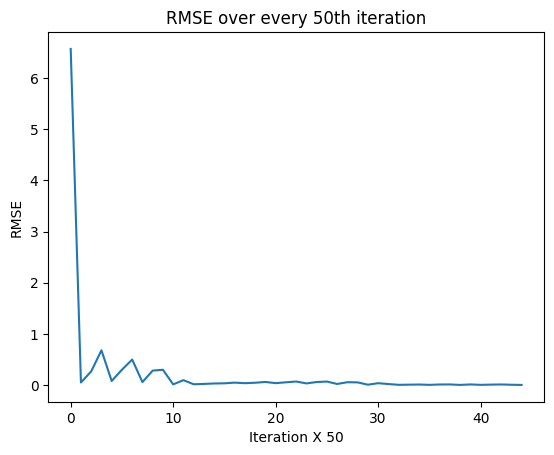

In [6]:
plot_losses(training_losses, 50)
mse, rmse = testing_accuracy(X_test, model, forecast_horizon, prediction_window)

## Saving the results

In [7]:
metrics = {"trend_accuracy": trend_accuracy, "mse": mse, "rmse": rmse}
with open("output/metrics.json", "w") as metrics_file:
    json.dump(metrics, metrics_file, indent=4)